In [1]:
from active_model import MLP, Conv
import active_model
import generate_data
import numpy as np
import math
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F


In [2]:
torch.manual_seed(0)

In [3]:
shared_features = ['v', 'q', 'pwm']
raw_data, options = generate_data.load_data(features = shared_features)

In [4]:
options["dim_x"] = 0
for f in shared_features:
  if len(raw_data[0][f].shape) < 2:
    options["dim_x"] += 1
  else:
    options["dim_x"] += raw_data[0][f].shape[1]

In [5]:
hidden_dim = [32,32]
num_task_data = 6
num_task = 6
subspace = [7,2]
spectral_norms = [False]*len(hidden_dim)
data_model = MLP(options["dim_x"], num_task, hidden_dim, spectral_norms, subspace, datamodel = True, random = False)

In [6]:
rng = np.tile([10], [1,30])
rng2 = np.arange(10,310,10)
# shared_features = options["features"]


In [48]:
test_data, test_label = generate_data.generate_task_sample(data_model, raw_data[0], shared_features, 6, 3000, False, comb=False)

In [49]:
target_data, target_label = generate_data.generate_task_sample(data_model, raw_data[0], shared_features, 6, 20, False, comb=False)

In [50]:
bw = np.dot(generate_data.B_matrics,generate_data.random_w)
def get_distance(x):
  return np.abs(np.dot(x, bw[:,-1])/(np.linalg.norm(x)*np.linalg.norm(bw[:,-1])))

In [10]:
eps = False

## Best

In [11]:
# generate_data.random_w = np.random.uniform(low=0, high=5, size=(6, 6))
# generate_data.random_w = np.concatenate((generate_data.random_w,np.zeros((1,6))),axis = 0 )
# generate_data.B_matrics = np.random.random((2 , 7))
# Bw = np.dot(generate_data.B_matrics,generate_data.random_w)
# generate_data.B_matrics[:,generate_data.B_matrics.shape[1]-1] = Bw[:, 0]
# w_target = np.zeros((7,1))
# w_target[w_target.shape[0]-1][0] = 1
# generate_data.random_w = np.concatenate((generate_data.random_w,w_target),axis = 1 )

In [12]:
shared_features = options["features"]
v = [1,0,0,0,0,0]

In [13]:
best_epoch_loss = []
best_predict_loss = []
best_target_predict_loss = []
best_target_train_loss = []
# test_data, test_label = generate_data.generate_task_sample(data_model, raw_data[0], shared_features,0, 500)
test_dataset = (test_data, torch.Tensor(test_label))
target_dataset = (target_data, torch.Tensor(target_label))
train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, 10, v, shared_features, eps=eps)
train_dataset = (train_x, train_y)
total_size = 10
hidden_dim = [32,32]
spectral_norms = [False]*len(hidden_dim)
best_model = MLP(options["dim_x"], 1, hidden_dim, spectral_norms,2, 6, False, True)
optimizer = optim.SGD(best_model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9) 
best_est_bw = []
bw = np.dot(generate_data.B_matrics,generate_data.random_w)
for sample_size in rng[0]:
  # total_size += sample_size
  # # train_dataset, test_dataset2 = generate_data.get_dataset(data_model, raw_data, options, sample_size, shared_features, v)
  # M = total_size
  # L = 1.1   # base length
  # K = 70   # model dimension
  # epoch = round(math.log(K*M,L))
  epoch = 0
  total_loss = 0
  prev_loss = np.inf
  total_loss = 0
  # for i in range(epoch):
  while True:
    loss = active_model.train_source(best_model, train_dataset, 6, optimizer, epoch, False)
    total_loss += loss
    scheduler.step()
    if loss >= prev_loss:
      break
    prev_loss = loss
    epoch += 1
  best_epoch_loss.append(total_loss/epoch)
  predict_loss = []
  for k in range(num_task):
    predict_loss.append(best_model.predict(test_dataset[0],test_dataset[1],k))
  best_predict_loss.append(predict_loss)
  best_model, best_w, train_loss = active_model.findTargetWeight(0.01,target_dataset,best_model,gamma=0.9, need_print = False)
  best_target_train_loss.append(train_loss)
  best_target_predict_loss.append(best_model.predict(test_dataset[0],test_dataset[1]))
  best_est_bw.append(np.array(best_model.last_layers[0].weight.detach())[0])
  train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, sample_size, v, shared_features, task_data=train_dataset, eps = False)
  train_dataset = (train_x, train_y)

Text(0.5, 1.0, 'best sampling training loss')

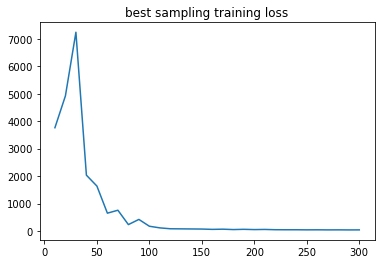

In [14]:
plt.plot(rng2,best_epoch_loss)
plt.title("best sampling training loss")

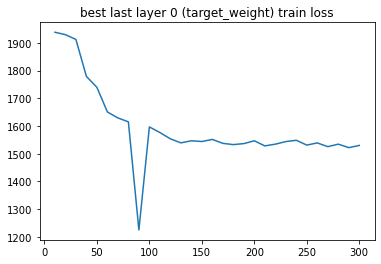

In [15]:
plt.title("best last layer 0 (target_weight) train loss")
plt.plot(rng2, np.array(best_target_train_loss))

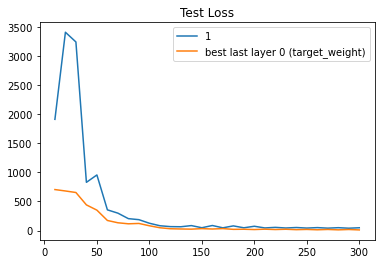

In [16]:
# target nn last layer loss
plt.plot(rng2, np.array(best_predict_loss).T[0], label=1)
# plt.plot(rng2, np.array(best_predict_loss).T[5], label=6)
plt.plot(rng2, np.array(best_target_predict_loss), label="best last layer 0 (target_weight)")
plt.legend()
plt.title("Test Loss")
plt.show()

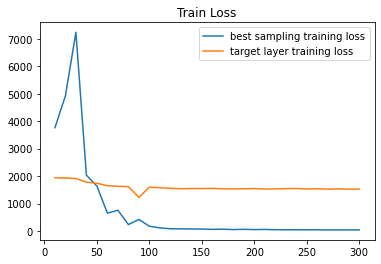

In [17]:
# target nn last layer loss
plt.plot(rng2, np.array(best_epoch_loss), label="best sampling training loss")
# plt.plot(rng2, np.array(best_predict_loss).T[5], label=6)
plt.plot(rng2, np.array(best_target_train_loss), label="target layer training loss")
plt.legend()
plt.title("Train Loss")
plt.show()

Text(0.5, 1.0, 'best similarity with target bw')

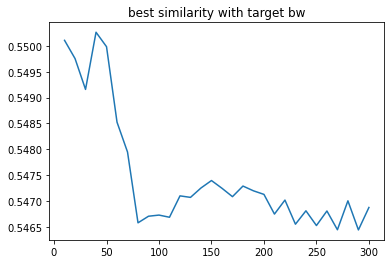

In [59]:
best_bw_dis = np.apply_along_axis(get_distance, 1, best_est_bw)
plt.plot(rng2,best_bw_dis)
plt.title("best similarity with target bw")


## Uniform

In [37]:
generate_data.random_w = np.identity(7)
bw = np.dot(generate_data.B_matrics,generate_data.random_w)

In [38]:
bw

array([[0.84650769, 0.20794451, 0.39930265, 0.08193904, 0.30672442,
        0.66461703, 1.21128415],
       [0.48126779, 0.90838827, 0.60932832, 0.96567902, 0.52060762,
        0.45069748, 1.64610721]])

In [52]:
uni_epoch_loss = []
uni_predict_loss = []
uni_target_loss = []
uni_target_predict_loss = []
uni_target_train_loss = []
uni_est_bw = []
# test_data, test_label = generate_data.generate_task_sample(data_model, raw_data[0], shared_features,0, 500)
test_dataset = (test_data, torch.Tensor(test_label))
target_dataset = (target_data, torch.Tensor(target_label))
train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, 10, v, shared_features, eps = eps)
train_dataset = (train_x, train_y)
total_size = 10
hidden_dim = [32,32]
spectral_norms = [False]*len(hidden_dim)
uni_model = MLP(options["dim_x"], 1, hidden_dim, spectral_norms, 2, num_task, False, True)
optimizer = optim.SGD(uni_model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=200, gamma=0.9)
for sample_size in rng[0]:
  # total_size += sample_size
  # # train_dataset, test_dataset2 = generate_data.get_dataset(data_model, raw_data, options, sample_size, shared_features, v)
  # M = total_size
  # L = 1.1   # base length
  # K = 70   # model dimension
  # epoch = int(math.log(K*M,L))
  epoch = 0
  total_loss = 0
  prev_loss = np.inf
  total_loss = 0
  # for i in range(epoch): 
  while True:
    loss = active_model.train_source(uni_model, train_dataset, 6, optimizer, epoch, False)
    total_loss += loss
    scheduler.step()
    if loss >= prev_loss:
      break
    prev_loss = loss
    epoch += 1
    
  uni_epoch_loss.append(total_loss/epoch)
  predict_loss = []
  for k in range(num_task):
    predict_loss.append(uni_model.predict(test_dataset[0],test_dataset[1],k)*epoch)
  uni_predict_loss.append(predict_loss)
  uni_model, best_w,target_loss = active_model.findTargetWeight(0.01,target_dataset,uni_model,gamma=0.9, need_print = False)
  uni_target_train_loss.append(target_loss)
  uni_target_predict_loss.append(uni_model.predict(test_dataset[0],test_dataset[1]))
  uni_est_bw.append(np.array(uni_model.last_layers[0].weight.detach())[0])
  train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, sample_size, v, shared_features, task_data=train_dataset, eps = eps)
  train_dataset = (train_x, train_y)
  

Text(0.5, 1.0, 'uniform sampling training loss')

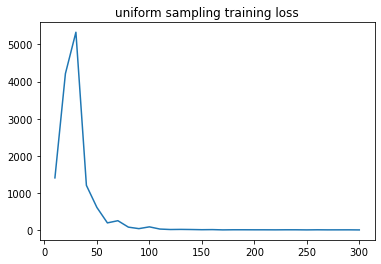

In [42]:
plt.plot(rng2,uni_epoch_loss)
plt.title("uniform sampling training loss")

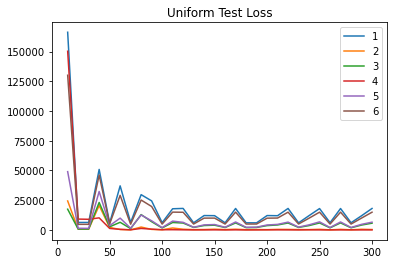

In [43]:
# last layer loss
for k in range(num_task):
    plt.plot(rng2, np.array(uni_predict_loss).T[k], label=k+1)
plt.legend()
plt.title("Uniform Test Loss")
plt.show()

Text(0.5, 1.0, 'active last layer 0 (target_weight)')

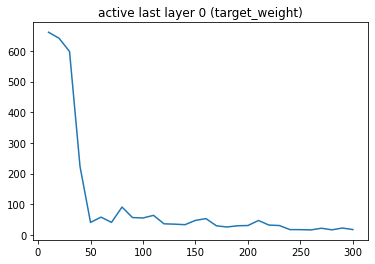

In [44]:
plt.plot(rng2, np.array(uni_target_predict_loss))
plt.title("active last layer 0 (target_weight)")

Text(0.5, 1.0, 'last layer 0 (target_weight) training loss')

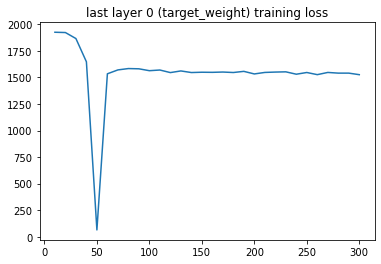

In [45]:
plt.plot(rng2, np.array(uni_target_train_loss))
plt.title("last layer 0 (target_weight) training loss")

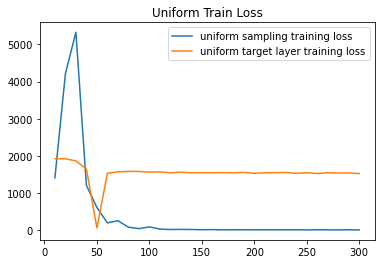

In [46]:
# target nn last layer loss
plt.plot(rng2, np.array(uni_epoch_loss), label="uniform sampling training loss")
# plt.plot(rng2, np.array(best_predict_loss).T[5], label=6)
plt.plot(rng2, np.array(uni_target_train_loss), label="uniform target layer training loss")
plt.legend()
plt.title("Uniform Train Loss")
plt.show()

Text(0.5, 1.0, 'uniform learning similarity with target bw')

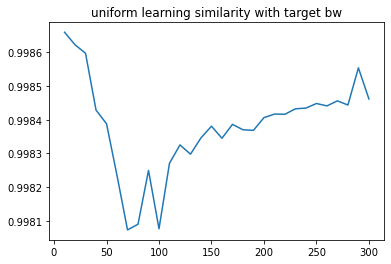

In [60]:
uni_bw_dis = np.apply_along_axis(get_distance, 1, uni_est_bw)
plt.plot(rng2,uni_bw_dis)
plt.title("uniform learning similarity with target bw")

## Compare

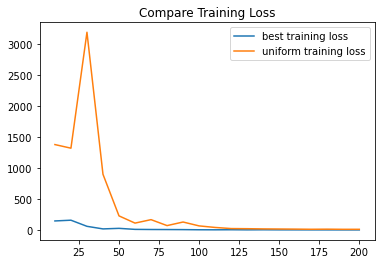

In [53]:
plt.plot(rng2,best_epoch_loss, label="best training loss")
plt.plot(rng2,uni_epoch_loss, label="uniform training loss")
plt.title("Compare Training Loss")
plt.legend()
plt.show()

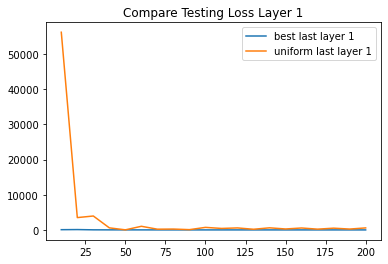

In [54]:
plt.plot(rng2, np.array(best_predict_loss).T[0], label="best last layer 1")
plt.plot(rng2, np.array(uni_predict_loss).T[0], label="uniform last layer 1")
plt.title("Compare Testing Loss Layer 1")
plt.legend()
plt.show()

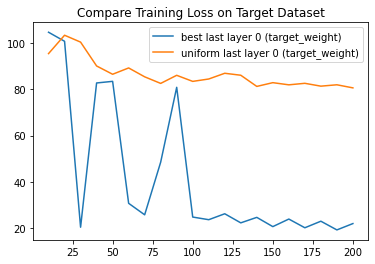

In [55]:
plt.plot(rng2, np.array(best_target_train_loss), label = "best last layer 0 (target_weight)")
plt.plot(rng2, np.array(uni_target_train_loss), label = "uniform last layer 0 (target_weight)")
plt.title("Compare Training Loss on Target Dataset")
plt.legend()
plt.show()


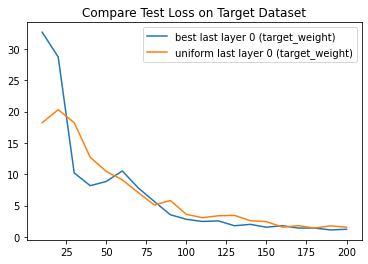

In [56]:
plt.plot(rng2, np.array(best_target_predict_loss), label = "best last layer 0 (target_weight)")
plt.plot(rng2, np.array(uni_target_predict_loss), label = "uniform last layer 0 (target_weight)")
plt.title("Compare Test Loss on Target Dataset")
plt.legend()
plt.show()

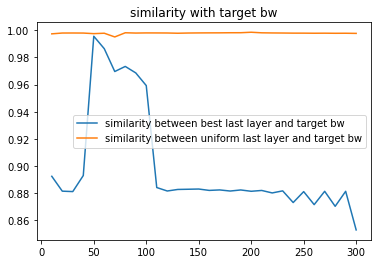

In [28]:
plt.plot(rng2, np.array(best_bw_dis), label="similarity between best last layer and target bw")
plt.plot(rng2, np.array(uni_bw_dis), label="similarity between uniform last layer and target bw")
plt.title("similarity with target bw")
plt.legend()
plt.show()

## Active

In [11]:
def apply_along_axis(function, x, axis: int = 0):
    return np.stack([
        function(x_i) for x_i in x
    ], axis=axis)

In [12]:
def update_v(ws, best_w):
  new_v = np.linalg.lstsq(ws.detach().numpy(), best_w.detach().numpy().T)[0]
  new_v = new_v.T
  return new_v

def estimate(model, input, true_y, num_task, v, best_w):
  results = []
  for task_id in range(num_task):
    result = model.predict(input, true_y, task_id)
    results.append(result)
  best_w_idx = np.argmin(results)
  ws = torch.ones_like(model.last_layers[0].weight)
  ws = ws.tile(num_task,1)
  for i, layer in enumerate(model.last_layers[1:]):
    ws[i] = layer.weight
    # if best_w_idx == i:
    #   best_w = layer.weight
  new_v = update_v(ws, best_w)
  new_v = np.squeeze(new_v)
  v = 0.8 * v + 0.2 * new_v
  v = np.apply_along_axis(lambda x: max(0.167, x), 0, [v])
  v = np.squeeze(v)
  v = np.abs(v/np.linalg.norm(v,2))
  return v, best_w

### Discrete

In [47]:
v = np.array([1]*len(raw_data))
v = v / (len(raw_data))

In [ ]:
active_epoch_loss = []
active_predict_loss = []
active_target_loss = []
# test_data, test_label = generate_data.generate_task_sample(data_model, raw_data[0], shared_features,0, 500)
test_dataset = (test_data, torch.Tensor(test_label))
train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, 10, v, shared_features)
train_dataset = (train_x, train_y)
total_size = 10
hidden_dim = [32,32]
spectral_norms = [False]*len(hidden_dim)
ac_model = MLP(options["dim_x"], 1, hidden_dim, spectral_norms, num_task, False, True)
optimizer = optim.SGD(ac_model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=200, gamma=0.9)

for sample_size in rng[0]:
  # total_size += sample_size
  # # train_dataset, test_dataset2 = generate_data.get_dataset(data_model, raw_data, options, sample_size, shared_features, v)
  # M = total_size
  # L = 1.1   # base length
  # K = 70   # model dimension
  # epoch = int(math.log(K*M,L))
  epoch = 0
  prev_loss = np.inf
  total_loss = 0
  # for i in range(epoch): 
  while True:
    loss = active_model.train_source(ac_model, train_dataset, 6, optimizer, epoch, False)
    total_loss += loss
    scheduler.step()
    if loss >= prev_loss:
      break
    prev_loss = loss
    epoch += 1
  active_epoch_loss.append(total_loss/epoch)
  predict_loss = []
  for k in range(num_task):
    predict_loss.append(ac_model.predict(test_dataset[0],test_dataset[1],k)*epoch)
  active_predict_loss.append(predict_loss)
  ac_model, best_w, e = findTargetWeight(0.0000001,test_dataset,ac_model,gamma=0.001, need_print = True)
  active_target_loss.append(ac_model.predict(test_dataset[0],test_dataset[1])/e)
  v, best_w = estimate(ac_model, test_dataset[0], test_dataset[1], num_task, v, best_w)
  train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, sample_size, v, shared_features, task_data=train_dataset)
  train_dataset = (train_x, train_y)
  

Text(0.5, 1.0, 'active sampling training loss')

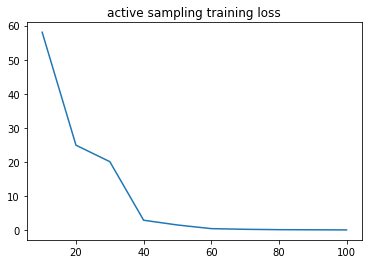

In [49]:
plt.plot(rng2,active_epoch_loss)
plt.title("active sampling training loss")

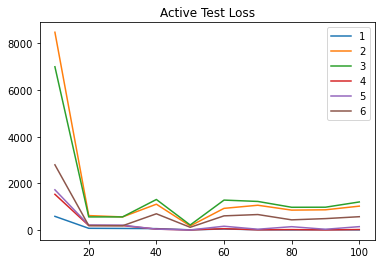

In [50]:
for k in range(num_task):
    plt.plot(rng2, np.array(active_predict_loss).T[k], label=k+1)
plt.legend()
plt.title("Active Test Loss")
plt.show()

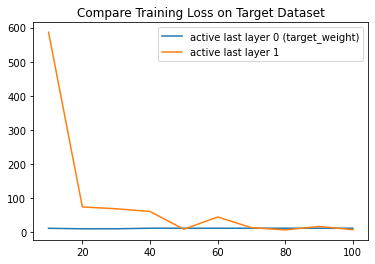

In [51]:
plt.plot(rng2, np.array(active_target_loss), label="active last layer 0 (target_weight)")
plt.plot(rng2, np.array(active_predict_loss).T[0], label="active last layer 1")
# plt.plot(rng2, np.array(active_predict_loss).T[5], label="active last layer 6")
plt.legend()
plt.title("Compare Training Loss on Target Dataset")
plt.show()

### Continuous

In [44]:
v_set = np.eye(7,7)
# v_set = np.concaten
# ate((v_set,[[1,0,0,0,0,0,0]]),axis = 0)

In [46]:
generate_data.random_w = np.random.uniform(low=0, high=1, size=(6, 6))
generate_data.random_w = np.concatenate((generate_data.random_w,np.zeros((1,6))),axis = 0 )
# generate_data.random_w = np.concatenate((generate_data.random_w,np.zeros((1,6))),axis = 0 )
generate_data.B_matrics = np.random.random((2 , 7))
w_target = np.zeros((7,1))
w_target[w_target.shape[0]-1][0] = 1
generate_data.random_w = np.concatenate((generate_data.random_w,w_target),axis = 1)
# generate_data.Bw = np.dot(generate_data.B_matrics,generate_data.random_w)
# target Bw is the on the same direction with source task 0
# generate_data.B_matrics[:,-1] = generate_data.B_matrics[:,0]
# generate_data.w_target = np.zeros((7,1))
# generate_data.w_target[generate_data.w_target.shape[0]-1][0] = 1
# generate_data.random_w = np.concatenate((generate_data.random_w,generate_data.w_target),axis = 1)

In [47]:
generate_data.Bw = np.dot(generate_data.B_matrics, generate_data.random_w)

In [ ]:
ac_epoch_loss = []
ac_predict_loss = []
ac_target_loss = []
ac_target_predict_loss = []
ac_target_train_loss = []
ac_est_bw = []
# test_data, test_label = generate_data.generate_task_sample(data_model, raw_data[0], shared_features,0, 500)
test_dataset = (test_data, torch.Tensor(test_label))
target_dataset = (target_data, torch.Tensor(target_label))
train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, num_task**2, [1/num_task]*num_task, shared_features)
train_dataset = (train_x, train_y)
total_size = 10
hidden_dim = [32,32]
spectral_norms = [False]*len(hidden_dim)
ac_model = MLP(options["dim_x"], 1, hidden_dim, spectral_norms, subspace, num_task, False, True)
optimizer = optim.SGD(ac_model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=200, gamma=0.9)
# SVD to find V0
generate_data.Bw = np.dot(generate_data.B_matrics,np.eye(7,7))
train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, 7*num_task, [1/num_task]*num_task, shared_features)
active_model.train_source(ac_model, (train_x, train_y), 6, optimizer, epoch, False)
est_bw = apply_along_axis(lambda x: np.array(x.weight.detach())[0],ac_model.last_layers)[1:]
u,s,vh = np.linalg.svd(est_bw.T)
for i in range(rng.shape[1]):
  if i >= 5:
    i = 5
  epsilon = 2**(-i)
  sample_size = round(1/(epsilon**(3/2)))
  print(sample_size)
  generate_data.Bw = np.dot(generate_data.B_matrics[:,:-1],vh)
  train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, sample_size*num_task, [1/num_task]*num_task, shared_features, task_data=train_dataset)
  epoch = 0
  total_loss = 0
  prev_loss = np.inf
  total_loss = 0
  while True:
    loss = active_model.train_source(ac_model, train_dataset, 6, optimizer, epoch, False)
    total_loss += loss
    scheduler.step()
    if loss >= prev_loss:
      break
    prev_loss = loss
    epoch += 1
    
  ac_epoch_loss.append(total_loss/epoch)
  predict_loss = []
  
  for k in range(num_task):
    predict_loss.append(ac_model.predict(test_dataset[0],test_dataset[1],k)*epoch)
  ac_predict_loss.append(predict_loss)
  
  # est_bw = apply_along_axis(lambda x: np.array(x.weight.detach())[0],ac_model.last_layers)[1:]
  est_bw = apply_along_axis(lambda x: np.array(x.weight.detach())[0],ac_model.last_layers)[1:]
  est_bww= np.dot(est_bw.T,generate_data.random_w[:-1,:-1])
  bw_dis = np.apply_along_axis(get_distance, 1, est_bww.T)
  v = np.zeros(num_task)
  v[np.argmin(bw_dis)] = 1
  generate_data.Bw = np.dot(generate_data.B_matrics,generate_data.random_w)
  # print("target sample_size", 1/(epsilon**2))
  # train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, 1/(epsilon**2), v, shared_features, task_data=train_dataset, eps = eps)
  train_x, train_y = generate_data.generate_sample_H(data_model, raw_data, options, 1/(epsilon**2), v, shared_features,eps = eps)
  active_train_dataset = (train_x, train_y)
  
  while True:
    loss = active_model.train_source(ac_model, active_train_dataset, 6, optimizer, epoch, False)
    total_loss += loss
    scheduler.step()
    if loss >= prev_loss:
      break
    prev_loss = loss
    epoch += 1   
    # train target
  ac_model, best_w,target_loss = active_model.findTargetWeight(0.01,target_dataset,ac_model,gamma=0.9, need_print = False)
  ac_target_train_loss.append(target_loss)
  ac_target_predict_loss.append(ac_model.predict(test_dataset[0],test_dataset[1]))
  ac_est_bw.append(np.array(ac_model.last_layers[0].weight.detach())[0])


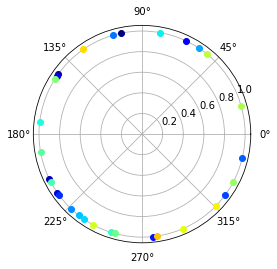

In [56]:
fig = plt.figure()
ax = fig.add_subplot(polar=True)
ac_bw_dis = np.apply_along_axis(get_distance, 1, ac_est_bw)
ac_bw_dis = np.arccos(ac_bw_dis)
n = ac_bw_dis.shape[0]
colors = plt.cm.jet(np.linspace(0,0.7,n))
for idx,i in enumerate(ac_bw_dis):
  ax.plot(i*1000,1,marker='o',color=colors[idx])


Text(0.5, 1.0, 'active sampling training loss')

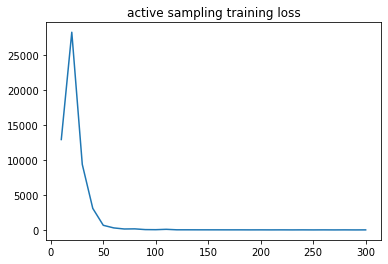

In [44]:
plt.plot(rng2,ac_epoch_loss)
plt.title("active sampling training loss")

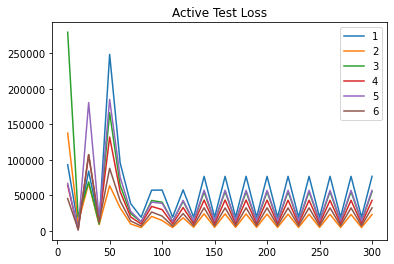

In [45]:
for k in range(num_task):
    plt.plot(rng2, np.array(ac_predict_loss).T[k], label=k+1)
plt.legend()
plt.title("Active Test Loss")
plt.show()

Text(0.5, 1.0, 'active last layer 0 (target_weight)')

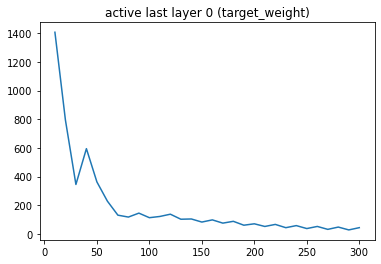

In [48]:
plt.plot(rng2, np.array(ac_target_predict_loss))
plt.title("active last layer 0 (target_weight)")

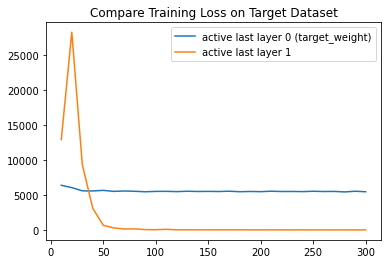

In [47]:
plt.plot(rng2, np.array(ac_target_train_loss), label="active last layer 0 (target_weight)")
plt.plot(rng2, np.array(ac_epoch_loss), label="active last layer 1")
# plt.plot(rng2, np.array(active_predict_loss).T[5], label="active last layer 6")
plt.legend()
plt.title("Compare Training Loss on Target Dataset")
plt.show()

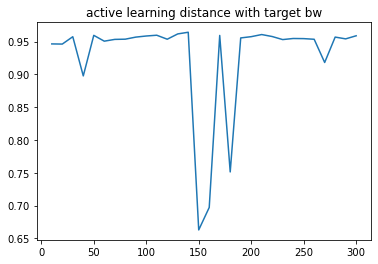

In [58]:
ac_bw_dis = np.apply_along_axis(get_distance, 1, ac_est_bw)
plt.title("active learning distance with target bw")
plt.plot(rng2,ac_bw_dis)

## Compare

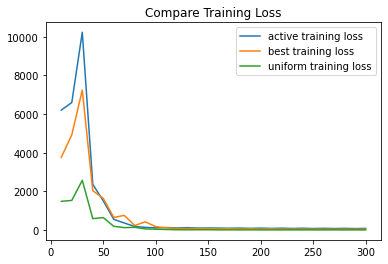

In [57]:
plt.plot(rng2,ac_epoch_loss, label="active training loss")
plt.plot(rng2,best_epoch_loss, label="best training loss")
plt.plot(rng2,uni_epoch_loss, label="uniform training loss")
plt.title("Compare Training Loss")
plt.legend()
plt.show()

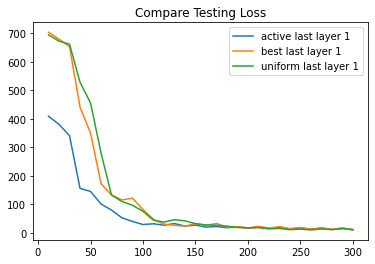

In [58]:
plt.plot(rng2, np.array(ac_target_predict_loss), label="active last layer 1")
# plt.plot(active_rng, np.array(active_predict_loss).T[5], label="active last layer 0")
plt.plot(rng2, np.array(best_target_predict_loss), label="best last layer 1")
plt.plot(rng2, np.array(uni_target_predict_loss), label="uniform last layer 1")

plt.title("Compare Testing Loss")
plt.legend()
plt.show()

In [ ]:
# plt.plot(rng2, np.array(active_predict_loss).T[5], label="active last layer 6")
# plt.plot(rng2, np.array(best_predict_loss).T[5], label="best last layer 6")
# plt.plot(rng2, np.array(uni_predict_loss).T[5], label="uniform last layer 6")
# plt.title("Compare Testing Loss")
# plt.legend()
# plt.show()